# IS318 - Machine Learning

## TP1 - Linear regression

The goal of this TP is to experiment with linear regression and polynomial linear regression.

First, we will work **without** the use of external libraries (such as `scikit-learn`).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### 1. Dataset

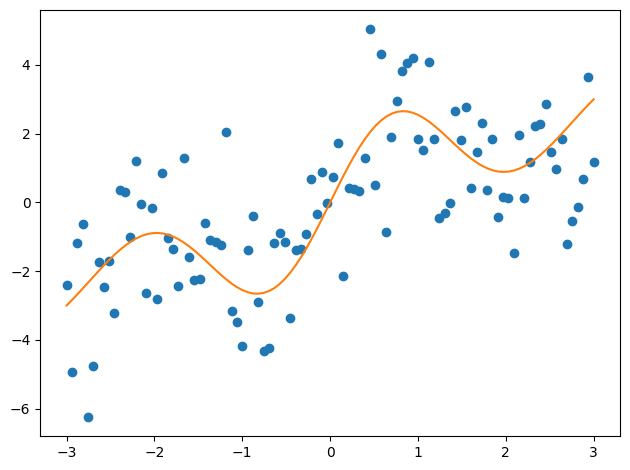

In [2]:
# Let us generate data points from a relatively complicated function
N = 100
alpha, sigma = 2., 3.
X = np.linspace(-3, 3, num=N)
y = X + (alpha * np.sin((2. * np.pi * X) / sigma) * np.exp(-(X ** 2) / (sigma ** 2)))
# Add some random noise
rng = np.random.default_rng(42)
y_noisy = y + rng.standard_normal(N) * 2.
# Show the data points
plt.plot(X, y_noisy, 'o')
plt.plot(X, y)
plt.tight_layout()

**(Question)** Shuffle and split the dataset into training (75%) and validation (25%) sets. Store the results into variables `X_train`, `y_train`, `X_valid`, `y_valid`.

*Hint:* you can use `rng.permutation` to generate a random permutation of the points.

In [3]:
points_permutated = rng.permutation(N)
X_shuffle = X[points_permutated]
X_train = X_shuffle[:75]
X_valid = X_shuffle[75:]
y_shuffle = y_noisy[points_permutated]
y_train = y_shuffle[:75]
y_valid = y_shuffle[75:]

In [4]:
assert X_train.shape == (75,)
assert y_train.shape == (75,)
assert X_valid.shape == (25,)
assert y_valid.shape == (25,)
assert np.any(X_valid != X[75:]) # points should be shuffled

### 2. Linear regression in 1D

Recall the 1D linear regression model, where we search for parameters $w_0, w_1$ that will satisfy $y_i = w_0 + w_1 x_i$ (for all $i$ in the training set).

To simplify calculations, we usually set $\textbf{w} = [w_0, w_1]^T$ and $\textbf{x}_i = [1, x_i]^T$.

Then we have $y_i = \textbf{w}^T \textbf{x}_i $.

**(Question)** Add a column with ones to the points in `X_train` and `X_valid`. Store the result in new variables `X_train_ones` and `X_valid_ones`:

In [5]:
X_train_ones = np.ones((np.shape(X_train)[0], 2))
X_valid_ones = np.ones((np.shape(X_valid)[0], 2))
for i in range(np.shape(X_train)[0]):
    X_train_ones[i][1] = X_train[i]
for i in range(np.shape(X_valid)[0]):
    X_valid_ones[i][1] = X_valid[i]

**(Question)** Use normal equations to find the parameters that minimize the mean squared error on the training set.

In [6]:
w = (np.linalg.inv(np.transpose(X_train_ones)@X_train_ones))@(np.transpose(X_train_ones)@y_train)

In [7]:
assert w.shape == (2,)

**(Question)** Plot the fitted line on top of the data points. Explain the result. (complete the code and answer in the cell below)

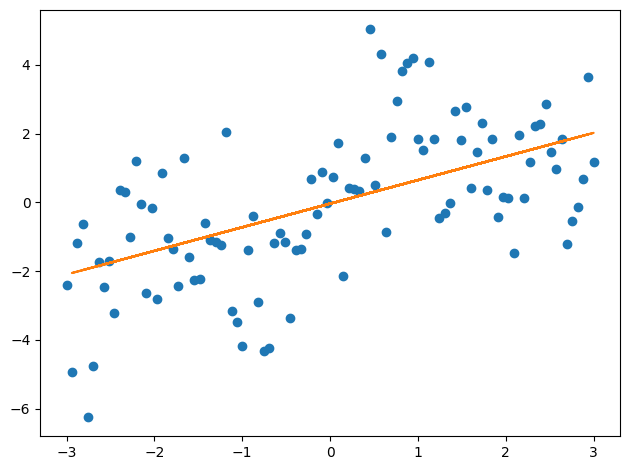

In [8]:
y_pred = X_train_ones@w
plt.plot(X, y_noisy, 'o')
plt.plot(X_train, y_pred)
plt.tight_layout()

We're underfitting here

**(Question)** Plot the loss function landscape. What can you conclude from this visualization? (complete the code and answer in the cell below)

*Hint: the loss landscape can be represented by a 2D map (for example of size 100x100) where in each coordinate $(w_0, w_1)$ the value is mean squared error for these parameters. You can use `plt.contourf` to visualize the result.*

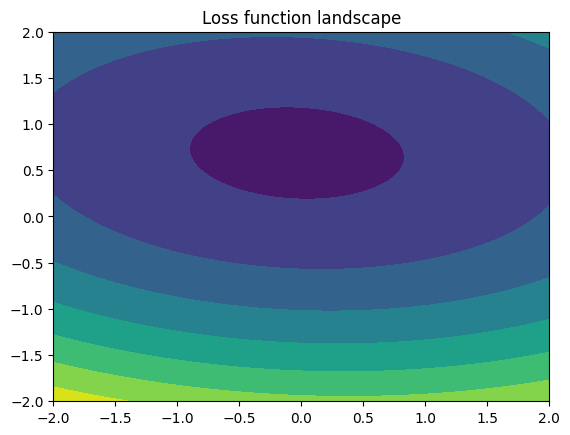

In [9]:
from matplotlib import ticker, cm

def loss(a, b):
    w = np.array([a,b])
    y_pred = X_train_ones@w
    return (1/N)*np.sum((np.transpose(y_pred-y_train))@(y_pred-y_train))

w0 = np.linspace(-2, 2, num=N)
w1 = np.linspace(-2, 2, num=N)
W0, W1 = np.meshgrid(w0, w1)
z = np.zeros(np.shape(W0))

for i in range(np.shape(z)[0]):
    for j in range(np.shape(z)[1]):
        z[i][j] = loss(W0[i][j], W1[i][j])

cs = plt.contourf(W0, W1, z)

plt.title('Loss function landscape')
plt.show()

We observe that for (-0.5, 0.8) we have the smallest error

### 3. Polynomial linear regression

We move on the polynomial linear regression model with degree $D$, where the relationship between $y_i$ and $x_i$ is
$ y_i = w_0 + w_1x_i + w_2x_i^2 + \ldots + w_D x_i^D $

With $\textbf{w} = [w_0, \ldots, w_D]^T$ and $\textbf{x}_i = [1, x_i, x_i^2, \ldots, x_i^D]^T$, we have $y_i = \textbf{w}^T \textbf{x}_i $.

$D \geq 1$ is an hyperparameter of the model.

**(Question)** Complete the following `PolynomialRegression` class

In [10]:
class PolynomialRegression():
    def __init__(self, D=1):
        assert D >=1
        self.D = D
        self.w = np.random.rand(D)
        
    def fit(self, X, y):
        '''Apply polynomial linear regression to fit `X` to `y`.
        The result should be stored in an attribute `w`.'''
        self.w = (np.linalg.inv(np.transpose(self.make_poly(X))@self.make_poly(X)))@(np.transpose(self.make_poly(X))@y)
        
    def predict(self, X):
        '''Assuming the model has already been fit, return
        predicted `y` values for given `X`.'''
        return self.make_poly(X)@self.w 

    def make_poly(self, X):
        '''Augment a dataset of 1D points (vector of size N) to its
        data matrix in polynomial form, including the zero column 
        (matrix of size N x D+1). Return the data matrix.'''
        assert X.ndim == 1
        col = np.ones(np.shape(X)[0])
        matrix = np.power(X,self.D)
        my_list = [np.power(X,self.D - i) for i in range(self.D+1)]
        matrix = np.stack(tuple(my_list))
        return np.transpose(matrix)

**(Question)** Implement the mean squared error function to measure the quality of predictions.

In [11]:
# I added two optional extra parameters to compute the loss function for the regularized version
def mean_squared_error(y_true, y_pred, lmbda=0, w=np.zeros(2)):
    '''Return the mean squared error between `y_true` and `y_pred`.'''
    assert y_true.shape == y_pred.shape
    return ((np.sum(np.transpose(y_true-y_pred)@(y_true-y_pred)))/len(y_true)) + lmbda*(np.transpose(w)@w)

In [12]:
a, b = np.random.randn(10), np.random.randn(10)
assert mean_squared_error(a, b) >= 0.
assert mean_squared_error(a, a) == 0.

**(Question)** Apply the polynomial regression model with $D=5$. Compute and print the mean squared error for the training and validation sets.

In [13]:
model = PolynomialRegression(D=5)
model.fit(X_train, y_train)
y_predicted = model.predict(X_valid)
print(mean_squared_error(y_valid, y_predicted))

3.321513387311656


**(Question)** Plot the fitted polynomial curve on top of the data points. Explain the result. (complete the code and answer in the cell below)

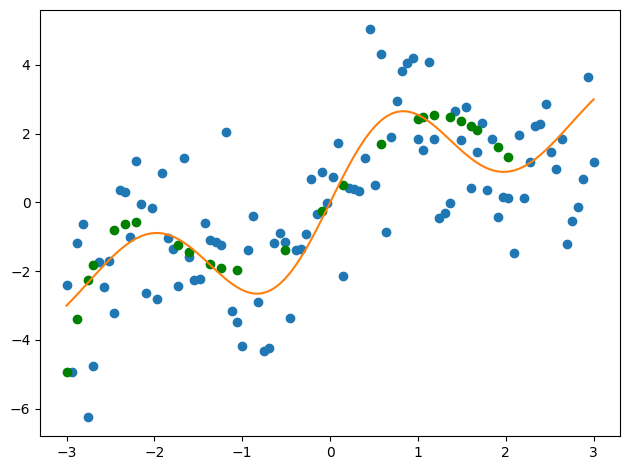

In [14]:
plt.plot(X, y_noisy, 'o')
plt.plot(X_valid, y_predicted, 'go')
plt.plot(X, y)
plt.tight_layout()

We approached our set of point with a polynomial of degree five we have acceptable results but before deciding if the value D=5 is the value that we'll choose we have to compare different values of D to take a decision

**(Question)** Using the validation set, implement a simple model selection strategy to optimize hyperparameter $D$ and print this value. For this question, you should limit the search to $D \in [1, 15]$.
To visualize potential underfitting and overfitting effects, plot the evolution of the error on the training and the validation sets for the different values of $D$.

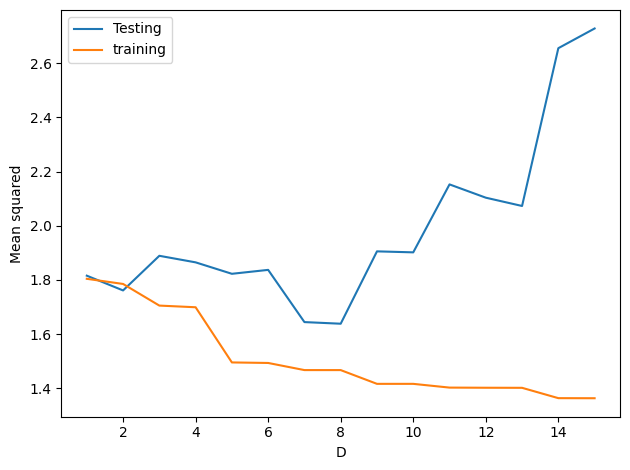

In [15]:
errors_training = []
errors_testing = []
for d in range(1,16):
    model = PolynomialRegression(D=d)
    model.fit(X_train, y_train)
    y_predicted = model.predict(X_valid)
    y_predicted_train = model.predict(X_train)
    errors_testing.append(np.sqrt(mean_squared_error(y_valid, y_predicted)))
    errors_training.append(np.sqrt(mean_squared_error(y_train, y_predicted_train)))
plt.plot([i for i in range(1,16)], errors_testing, label='Testing')
plt.plot([i for i in range(1,16)], errors_training, label='training')
plt.xlabel('D')
plt.ylabel('Mean squared')
plt.legend()
plt.tight_layout()

**(Question)** Plot the fitted polynomial curve of the best model on top of the data points. Comment the results.

2.703261599036465


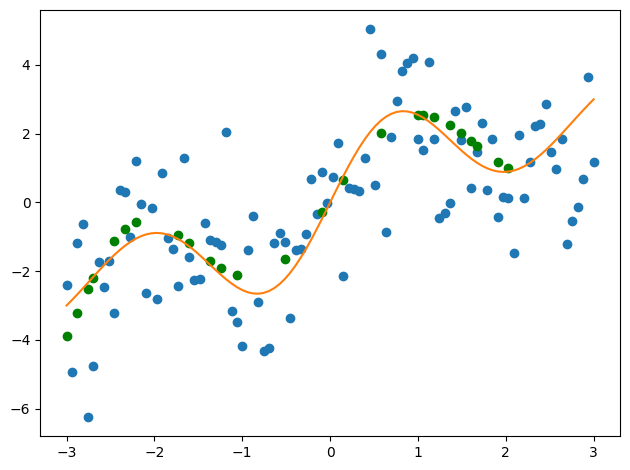

In [16]:
model = PolynomialRegression(D=7)
model.fit(X_train, y_train)
y_predicted = model.predict(X_valid)
print(mean_squared_error(y_valid, y_predicted))
plt.plot(X, y_noisy, 'o')
plt.plot(X_valid, y_predicted, 'go')
plt.plot(X, y)
plt.tight_layout()

We have a acceptable fit to our data points but we could try to reduce a little bit the overfitting

### 4. Regularized polynomial regression

Now, we want to implement polynomial regression with *weight decay* regularization:
$\hat{L}(\textbf{w}) = \frac{1}{N} \lVert \textbf{X} \textbf{w} - \textbf{y} \rVert^2 + \lambda \lVert\textbf{w}\rVert^2$

Here, $\lambda \geq 0$ is another hyperparameter of our model.

In [17]:
class RegularizedPolynomialRegression():
    def __init__(self, D=1, lmbda=1.):
        assert D >=1 and lmbda >= 0.
        self.D = D
        self.lmbda = lmbda
        
    def fit(self, X, y):
        '''Apply polynomial linear regression to fit `X` to `y`.
        The result should be stored in an attribute `w`.'''
        I = np.ones_like(np.transpose(self.make_poly(X))@self.make_poly(X))
        self.w = np.linalg.inv(self.lmbda*I + np.transpose(self.make_poly(X))@self.make_poly(X))@(np.transpose(self.make_poly(X))@y)
    def predict(self, X):
        '''Assuming the model has already been fit, return
        predicted `y` values for given `X`.'''
        return self.make_poly(X)@self.w 

    def make_poly(self, X):
        '''Augment a dataset of 1D points (vector of size N) to its
        data matrix in polynomial form, including the zero column 
        (matrix of size N x D+1). Return the data matrix.'''
        assert X.ndim == 1
        col = np.ones(np.shape(X)[0])
        matrix = np.power(X,self.D)
        my_list = [np.power(X,self.D - i) for i in range(self.D+1)]
        matrix = np.stack(tuple(my_list))
        return np.transpose(matrix)

**(Question)** Apply regularized linear regression and play around with hyperparameters $D$ and $\lambda$. Plot the result.

4.473826604628349


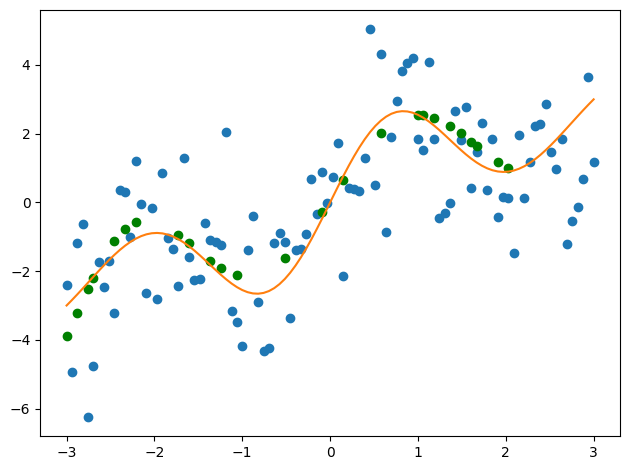

In [18]:
model = RegularizedPolynomialRegression(D=7, lmbda=0.1)
model.fit(X_train, y_train)
y_predicted = model.predict(X_valid)
print(mean_squared_error(y_valid, y_predicted, model.lmbda, model.w))
plt.plot(X, y_noisy, 'o')
plt.plot(X_valid, y_predicted, 'go')
plt.plot(X, y)
plt.tight_layout()

### 5. Comparison with `sklearn`

In [19]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge

**(Question)** Use the `sklearn` classes imported above to apply polynomial regression on our toy dataset. Compare the results with your implementation.

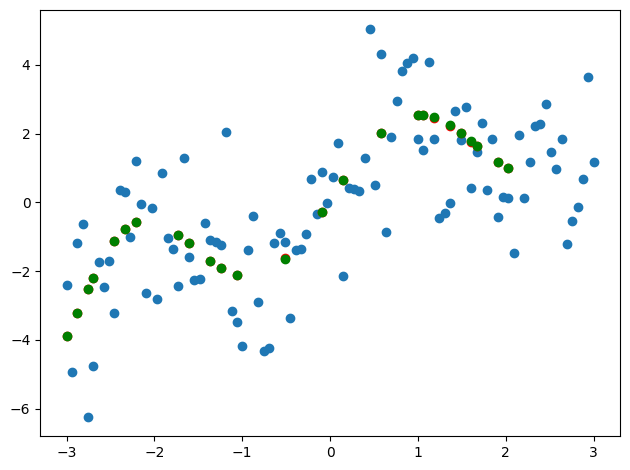

In [20]:
poly = PolynomialFeatures(7)
X_train_reshaped = X_train.reshape(-1, 1)
X_poly = poly.fit_transform(X_train_reshaped)
poly.fit(X_train_reshaped, y_train)
mod = LinearRegression()
mod.fit(X_poly, y_train)
X_valid_reshaped = X_valid.reshape(-1, 1)
y_pred = mod.predict(poly.fit_transform(X_valid_reshaped))
plt.plot(X, y_noisy, 'o')
plt.plot(X_valid, y_predicted, 'ro')
plt.plot(X_valid, y_pred, 'go')
plt.tight_layout()

We see that the two implementation are nearly the same the red points are predicted by scikit-learn model the green ones are predicted by our model